In [2]:
%matplotlib notebook
import logging

from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
from matplotlib import cm
# import scqubits as scq
# from scipy.optimize import curve_fit
from quantum_builder import QuantumBuilder
import ipywidgets
import matplotlib.gridspec as gridspec
import os

# plt.style.use('support-files/qubit.mplstyle')
plt.style.use('support-files/qubit-01.mplstyle')

FLUX = float
FLUX_NUMBER = int

cos = np.cos
sin = np.sin
pi = np.pi

fF = 10 ** (-15)
c = 10**(-10) #F/m Capacitance on interface
h = 6.64 * 10**(-34)
e = 1.6 * 10**(-19)
um = 10**(-6)
GHz = 10**(9)
kOhm = 10**3
Rq = 6.484*kOhm
Delta = 3.1*10**(-23) # Superconducting delta
Phi0 = h/(2 * e)
Gauss = 10**(-4) # Gauss to Wb/m²

MY_COLOURS = {
    "DarkBlue": "#104e8b",     # dark blue (DodgerBlue4)
    "DarkRed": "#ed2200",     # dark red (red2)
    "Green": "#9acd32",     
    "Orange": "#ffc125",      # orange,
    "LightBlue": "#68838b",  # light steel blue,
    "Purple": "#6959cd",  # dark purple
    "Pink": "#ffa07a",  # pink salmon,
    "Sky": "#00bfff",
}
CMAPS =  ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
COLORMAP_01 = ["#79cdcd", "#eead0e", "#9a37ff", "#00ee76"]
COLORMAP_12 = plt.get_cmap('Reds')
COLORMAP_ENERGY = plt.get_cmap('viridis')
COLORMAP_STATE = plt.get_cmap('hsv')

R_square_room_temperature = {'Dynamic-20sccm': 6700.0, 'Static-0.4mBar': 17000, 'Static-0.25mBar': 12170.0, 'Static-0.1mBar': 5670.0, 'Static-0.13mBar': 8000}
RESISTANCE_COLD_SCALING = 1.1

def eval_expected_ej0(resistance_rt):
    EJ0 = Rq / (resistance_rt * RESISTANCE_COLD_SCALING) * Delta / 2
    return EJ0/h/GHz

def eval_resitance_from_ej0(x_side: float, y_side: float, EJ0: float):
    N_squares= x_side/100 * y_side/100
    EJ0 = EJ0 * h * GHz
    return Rq * N_squares * Delta / 2 / EJ0 / kOhm

def c_interdigitated(W: float, L: float, N: int):
    return c * N * (W + L)

def ec_interdigitated(W: float, L: float, N: int):
    C = c * N * (W + L)
    Ec = e**2 / (2 * C) / h / GHz
    return Ec

GHz = 10**9

#plt.style.use('support-files/qubit.mplstyle')

def to_dBm(array):
    # Conver to dBm. Values smaller than 0 are set to the lowest value in array
    min_value = 10 * np.log10(min(array[array > 0]))
    return 10 * np.nan_to_num(np.log10(array), nan = min_value, neginf=min_value)

def from_dBm(array):
    return np.power(10, array / 10)

def rabi_model(t, tDec, T, A, B, C, D, *args):
    """
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B) + C
    """

    return A * np.sin(2 * np.pi * t / T + B) * np.exp(-t / tDec) + C*t + D

def rabi_model_beating(t, t_dec, T, A, B, C, D, E, t_beat):
    """
    OLD! Need to move t_beat to the end!
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B)sin(2π t / t_beat + E) + Ct + D
    """

    return A * np.sin(2 * np.pi * t / T + B) * np.sin(2 * np.pi * t / t_beat + E) *  np.exp(-t / t_dec) + C*t + D

# Mfield

In [6]:
# Load 3d data
FILENAME = "./data/2017-12-01_single-photon/Photon_Source_Dec8'17_mfield_02_data.txt"
OFFSET = 0.09
PERIOD = -(-0.07767 - 0.00785)

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    data3d_x = (data3d_x) / PERIOD - OFFSET
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0])
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

Spectral data:   0%|          | 0/201 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


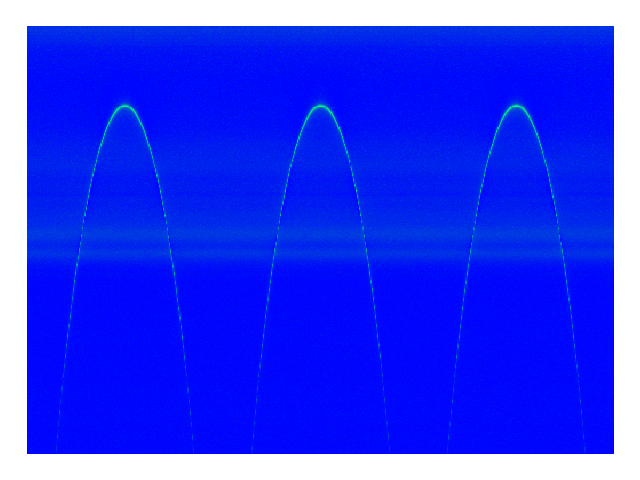

In [10]:
# Fitting Parameters
EC = 0.77
EJ0 = 4.9
FLUX_LIST = np.linspace(-1.5, 1.5, 201)

# Fitting
fitted = scq.TunableTransmon(
    EJmax=2*EJ0,
    EC=EC,
    d=0,       # no assymerty
    flux=0.0,  # defaults
    ng=0.0,
    ncut=21
)
fitted_01 = fitted.get_spectrum_vs_paramvals(param_name='flux',
                                             param_vals=FLUX_LIST,
                                             evals_count=2,
                                             subtract_ground=True
                                             ).energy_table[:, 1]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.winter)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax.axis('off') 

# fitted_plot, = ax.plot(FLUX_LIST, fitted_01,
#                        color=MY_COLOURS["Sky"],
#                        label="Fitted",
#                        linewidth=0.2,
#                        alpha=1,
#                        linestyle='-')
# ax.set_xlabel("$\Phi_{ext}/\Phi_0$", fontsize=15)
# ax.set_ylabel("$\omega/2\pi$ (GHz)", fontsize=15)

ax.set_ylim([4.5, 7.5])
ax.set_xlim([-1.5, 1.5])
plt.tight_layout()
ffc125ff
plt.savefig(FILENAME.replace("txt", "png"), dpi=300, transparent=True, bbox_inches='tight',pad_inches=0.0)
# plt.savefig(FILENAME.replace("txt", "svg"), dpi=300, transparent=True, bbox_inches='tight')

In [35]:
CONTINUOUS_UPDATE = False
def update(EC, EJ0):
    
#     ax.set_title(f"$E_C={EC:.2f}\,$GHz, $E_{{J0}}={EJ0:.2f}\,$GHz, $R={eval_resitance_from_ej0(JJ_side, JJ_side, EJ0):.2f}$k$\Omega$", fontsize=16)
    scq_energies = scq.TunableTransmon(
        EJmax=2*EJ0,
        EC=EC,
        d=0,       # no assymerty
        flux=0.0,  # defaults
        ng=0.0,
        ncut=21
        ).get_spectrum_vs_paramvals(param_name='flux',
                                                      param_vals=FLUX_LIST,
                                                      evals_count=2,
                                                      subtract_ground=True
                                                      ).energy_table
    fitted_plot.set_ydata(scq_energies[:, 1])
    
#     ax.relim()
#     ax.autoscale_view()
    
EC_widget = ipywidgets.FloatSlider(
    min=0.01, max=2, step=0.01,
    description="$E_{C}$ (GHz)", value=EC,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
EC_widget.style.handle_color = 'red'
EJ0_widget = ipywidgets.FloatSlider(
    min=1, max=100,
    description="$E_{J0}$ (GHz)", value=EJ0,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
EJ0_widget.style.handle_color = 'red'

offset_widget = ipywidgets.FloatSlider(
    min=-0.2, max=0.2, step=0.001,
    readout_format='.4f',
    description="offset", value=OFFSET,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
multiplier_widget = ipywidgets.FloatSlider(
    min=0.1, max=20, step=0.1,
    description="multiplier", value=PERIOD,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
toggle_widget = ipywidgets.Checkbox(
    description='Toggle Expected',
    value=False,
    continuous_update=CONTINUOUS_UPDATE
)

ui = ipywidgets.GridspecLayout(5, 1)
ui[0, :] = EC_widget
ui[1, :] = EJ0_widget
# ui[2, :] = offset_widget
# ui[3, :] = multiplier_widget
# ui[4, :] = toggle_widget

out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "EC": EC_widget,
        "EJ0": EJ0_widget,
#         "offset": offset_widget,
#         "multiplier": multiplier_widget,
#         "toggle_experiment": toggle_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatSlider(value=0.58, continuous_update=False, description='$E_{C}$ (GHz)', layout=…

Output()

<IPython.core.display.Javascript object>


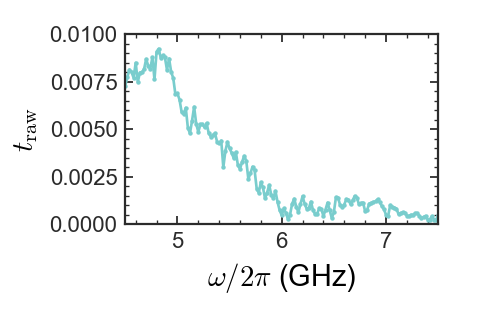

In [24]:
FILENAME = "./data/2021-05_amplifier-calibration/2017-ay-high-res.txt"
DATA = np.loadtxt(FILENAME)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.plot(DATA[:,0],DATA[:,1],marker="o",markersize=1, color="C4")
ax.set_xlim([4.5,7.5])
ax.set_ylim([0,0.01])
ax.set_xlabel("$\omega/2\pi$ (GHz)")
ax.set_ylabel(r"$t_\mathrm{{raw}}$")

# ax.spines['bottom'].set_color('white')
# ax.spines['top'].set_color('white')
# ax.spines['left'].set_color('white')
# ax.spines['right'].set_color('white')
# ax.xaxis.label.set_color('white')
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
plt.tight_layout()

plt.savefig(FILENAME.replace(".txt",".svg"))

# Power measurements

<IPython.core.display.Javascript object>


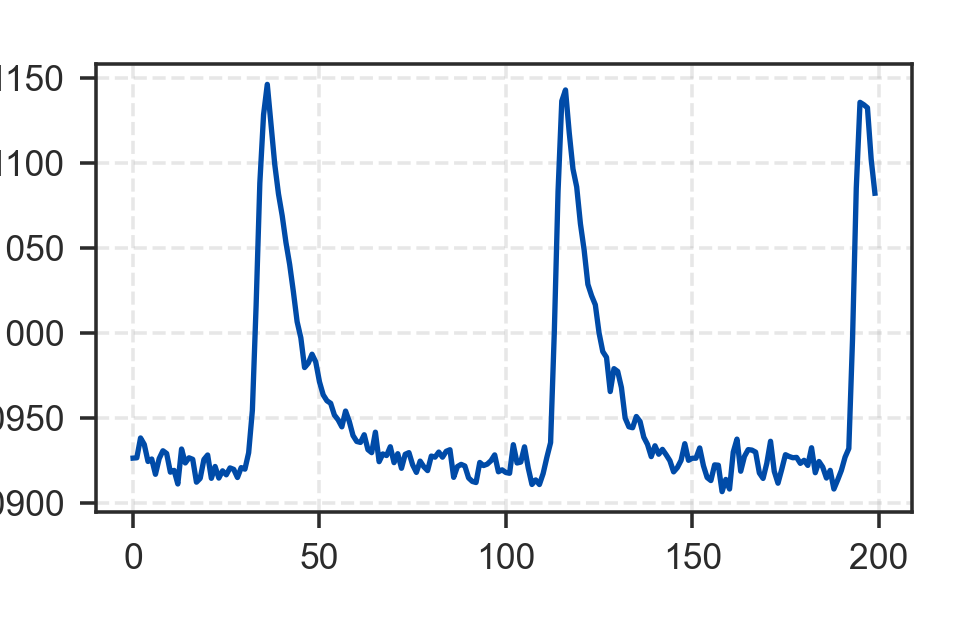

In [6]:
a = np.loadtxt("/Users/CCCP/creamy_seas/monday_starts_on_saturday/lab-results/2017-12-01_single-photon/2017_gnuplot/2018_04(April)_first_correlations/c++_Mar'18_piPulse(0)_98MHz.txt")
plt.plot(a[:,2])

# Smith alternative 

In [150]:
def transmission_model(dw, Omega, Gamma1=14, Gamma2=5,eta=0.8):
    r0 = eta*Gamma1 / (2 * Gamma2)
    
    tranRe = 1 - r0 / (1 + (dw/Gamma2)**2 + Omega**2/(Gamma1*Gamma2))
    
    return tranRe
from scipy.optimize import curve_fit 

<IPython.core.display.Javascript object>


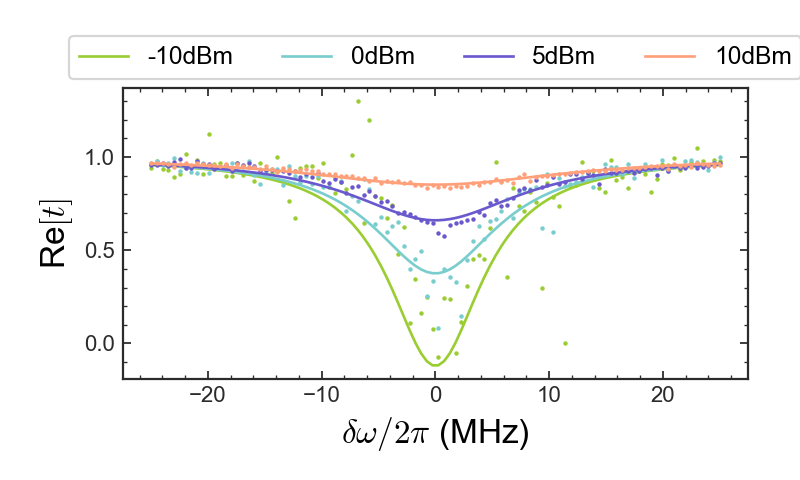

 /Users/CCCP/.config/python_vi/qubit/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py: 906

[0.]
[7.4584354]
[12.68896455]
[21.44265753]


In [159]:
FILENAME = "/Users/CCCP/creamy_seas/monday_starts_on_saturday/lab-results/2017-12-01_single-photon/2017_gnuplot/2017_12(Dec)_03_(first_photon_measurement)/labView_Photon_Source_Dec8'17_smith_06_data-v2.txt"

SCALER = 40
SHIFT = 1

DATA = np.loadtxt(FILENAME) / SCALER + SHIFT
N = DATA.shape[1]
freq = np.linspace(-25, 25, 100)

fig, ax = plt.subplots(1,1,figsize = (5,3))
cmap = plt.cm.afmhot(np.linspace(0, 1, N))

labels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15]
FITS = {
    1: (5, 14.4, 7.2),
    2: (0.001, 26.30, 26.30/2),
    3: (0.001, 26.31, 26.31/2),
    4: (5, 14.4, 7.2),
    5: (0, 10, 5),
#     6: (0.001, 26.31, 26.31/2, 0.0005),
}

COLOR = "C2"
IDX = 4
Omega, Gamma1, Gamma2, = (0, 10, 5)
popt, _ = curve_fit(
    transmission_model, 
    freq, 
    DATA[:,IDX],
    p0 = [Omega, 
#           Gamma1, Gamma2
         ]
)
print(popt)
ax.plot(freq, DATA[:,IDX], color=COLOR, linestyle="", marker="o", markersize=1)
ax.plot(freq, transmission_model(freq, *popt),'r', color=COLOR, markersize=1, label=f"{labels[IDX]}dBm") #plot fit

COLOR = "C4"
IDX = 6
Omega, Gamma1, Gamma2, = (0.01, 10, 5)
popt, _ = curve_fit(
    transmission_model, 
    freq, 
    DATA[:,IDX],
    p0 = [Omega
#           , Gamma1, Gamma2
         ]
)
print(popt)
ax.plot(freq, DATA[:,IDX], color=COLOR, linestyle="", marker="o", markersize=1)
ax.plot(freq, transmission_model(freq, *popt),'r', color=COLOR, markersize=1, label=f"{labels[IDX]}dBm")

COLOR = "C5"
IDX = 7
Omega, Gamma1, Gamma2, = (0.01, 10, 5)
popt, _ = curve_fit(
    transmission_model, 
    freq, 
    DATA[:,IDX],
    p0 = [Omega
#           , Gamma1, Gamma2
         ]
)
print(popt)
ax.plot(freq, DATA[:,IDX], color=COLOR, linestyle="", marker="o", markersize=1)
ax.plot(freq, transmission_model(freq, *popt),'r', color=COLOR, markersize=1, label=f"{labels[IDX]}dBm")

COLOR = "C6"
IDX = 8
Omega, Gamma1, Gamma2, = (0.01, 10, 5)
popt, _ = curve_fit(
    transmission_model, 
    freq, 
    DATA[:,IDX],
    p0 = [Omega,
#           Gamma1, Gamma2
         ]
)
print(popt)
ax.plot(freq, DATA[:,IDX], color=COLOR, linestyle="", marker="o", markersize=1)
ax.plot(freq, transmission_model(freq, *popt),'r', color=COLOR, markersize=1, label=f"{labels[IDX]}dBm")

ax.set_xlabel("$\delta\omega/2\pi$ (MHz)", fontsize=15)
ax.set_ylabel("Re$[t]$", fontsize=15)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0, 1.02, 1,0.2), 
    ncol = 4,
)   
plt.tight_layout()
    
# plt.savefig(FILENAME.replace("txt", "png"), dpi=300, transparent=True, bbox_inches='tight')
plt.savefig(FILENAME.replace("txt", "pdf"), dpi=300, transparent=True, bbox_inches='tight')

In [88]:
FITS[IDX]

(5, 14.4, 7.2, 0.0006)

# Smith

In [100]:
def transmission_model(w, Omega, Gamma1, Gamma2):
    """
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B) + C
    """
    dw = w
    r0 = Gamma1 / (2 * Gamma2)
#     r0 = 1
    
    reflection = r0 / (1 + (dw/Gamma2)**2 + Omega**2/(Gamma1*Gamma2))
    real = reflection
    imag = - reflection * dw / Gamma2
    
    return real
from scipy.optimize import curve_fit 

<IPython.core.display.Javascript object>


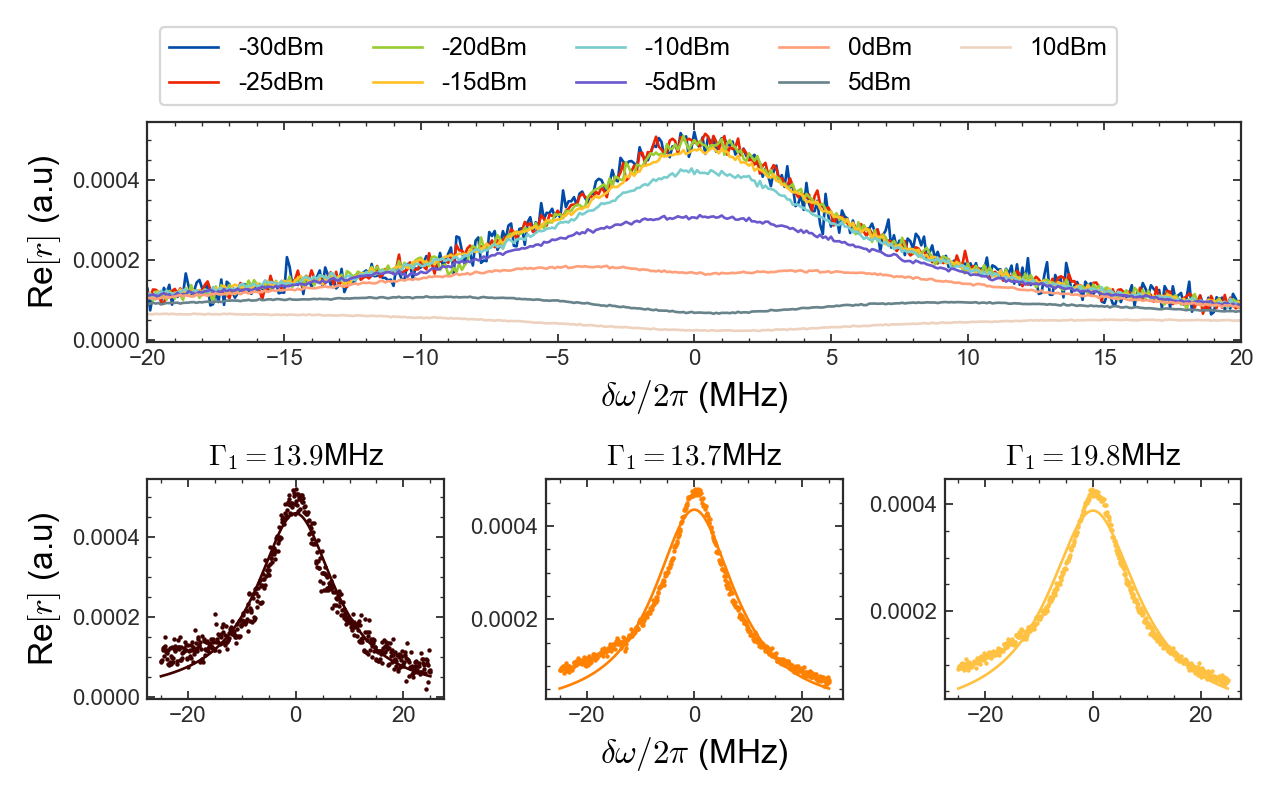

In [102]:
FILENAME = "/Users/CCCP/creamy_seas/monday_starts_on_saturday/lab-results/2017-12-01_single-photon/2017_gnuplot/2017_12(Dec)_03_(first_photon_measurement)/labView_Photon_Source_Dec8'17_smith_06_data.txt"

DATA = np.loadtxt(FILENAME)
N = DATA.shape[1]
freq = DATA[:,0]

fig = plt.figure(figsize = (8,5))
ax = plt.subplot(211)
cmap = plt.cm.afmhot(np.linspace(0, 1, 9))


labels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15]
for i in range(1, N):
    ax.plot(freq, DATA[:,i], label=f"{labels[i-1]}dBm")    
ax.legend(
    loc='lower left',
    bbox_to_anchor=(0, 1.02, 1,0.2), 
    ncol = 5
)   
ax.set_xlim([-20,20])
ax.set_xlabel("$\delta\omega/2\pi$ (MHz)", fontsize=15)
ax.set_ylabel("Re$[r]$ (a.u)", fontsize=15)

fits = {
    1: (5, 14.4, 7.2, 0.0006),
#     2: (0.001, 26.30, 26.30/2, 0.0005),
#     3: (0.001, 26.31, 26.31/2, 0.0005),
    4: (5, 14.4, 7.2, 0.0006),
    5: (10, 18.2, 7.2, 0.00058),
#     6: (0.001, 26.31, 26.31/2, 0.0005),
}

idx = 234
col = 1
for i, (Omega, Gamma1, Gamma2, A) in fits.items():
    popt, _ = curve_fit(transmission_model, freq, DATA[:,i]/A,
                           p0 = [
                               Omega, Gamma1, Gamma2]
                          )
#     print(popt)
    ax = plt.subplot(idx)
    if (i==1):
        ax.set_ylabel("Re$[r]$ (a.u)", fontsize=15)
    if (i==4):
        ax.set_xlabel("$\delta\omega/2\pi$ (MHz)", fontsize=15)
        
    ax.plot(freq, DATA[:, i], color=cmap[i], linestyle="", marker="o", markersize=1)
    ax.plot(freq, A*transmission_model(freq, *popt),'r',label='Fit', color=cmap[i], markersize=1) #plot fit
    ax.set_title(f"$\Gamma_1 = {popt[1]:.1f}$MHz", size=13)
#     ax.plot(freq, A*transmission_model(freq, Omega, Gamma1, Gamma2),'r',label='Fit', color=f"C{col}") #plot fit
    idx += 1
    col += 1
    
plt.tight_layout()
    
# plt.savefig(FILENAME.replace("txt", "png"), dpi=300, transparent=True, bbox_inches='tight')
# plt.savefig(FILENAME.replace("txt", "pdf"), dpi=300, transparent=True, bbox_inches='tight')

In [212]:
def from_dB_to_vGain(dB):
    return 10**(dB / 20)

RT = -30
IN = -60
AMP = 35 + 65

SCALING = RT + IN + AMP

SCALING_CORRECTION = from_dB_to_vGain(SCALING)
from_dB_to_vGain(30) * 5

158.11388300841895

<IPython.core.display.Javascript object>


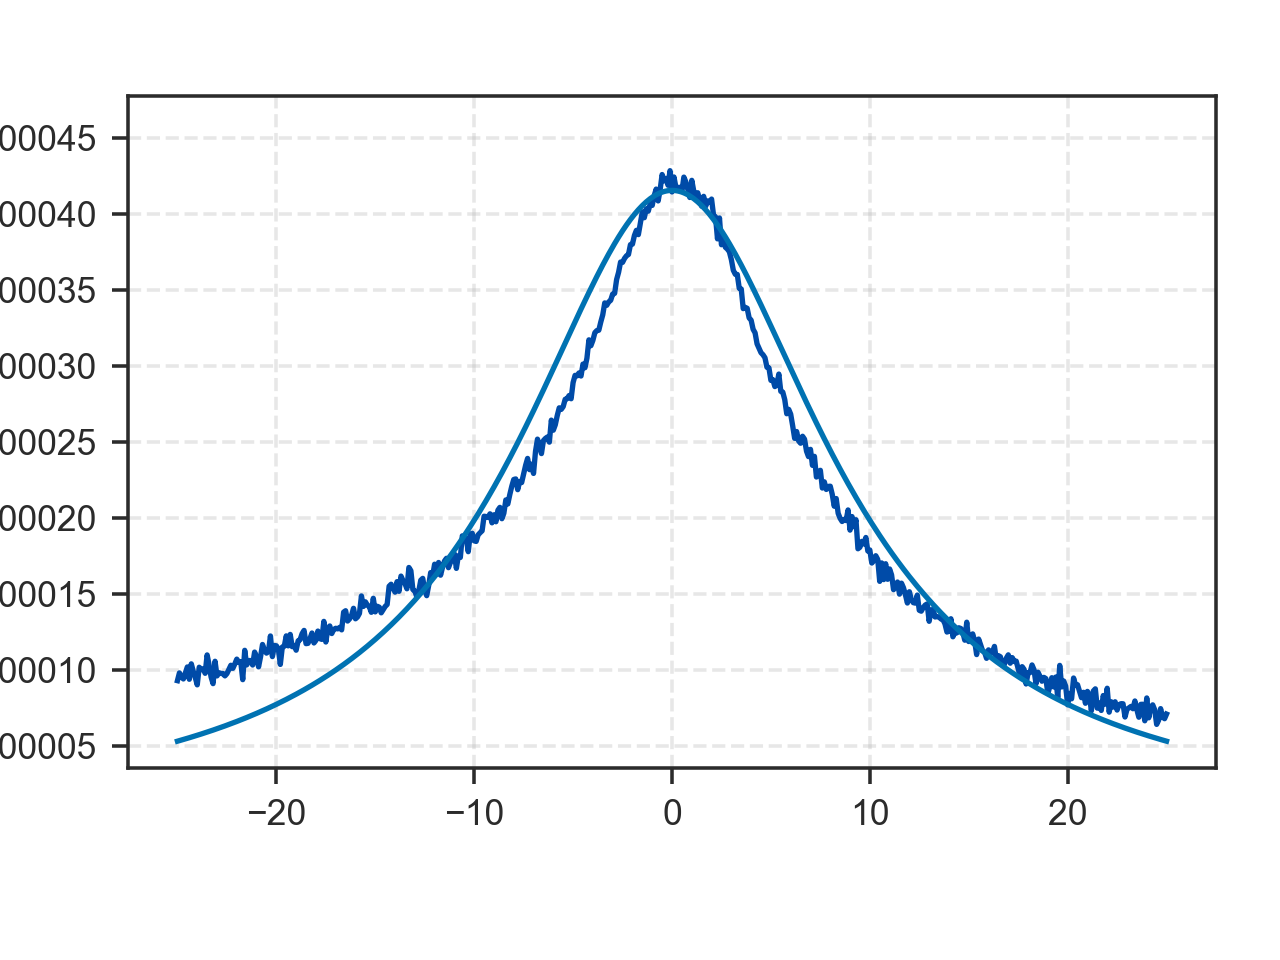

In [216]:
N = 5
Omega = 10
Gamma1 = 18.8
Gamma2 = 7

scaling_corr = 0.0006

fig, ax = plt.subplots(1, 1, figsize=(4,3))
ax.plot(freq, DATA[:, N])

re_sim, = ax.plot(freq, scaling_corr*transmission_model(freq, Omega, Gamma1, Gamma2)) #plot fit

def update(Omega, Gamma1, Gamma2, scaling_corr):
    simulation = transmission_model(freq, Omega, Gamma1, Gamma2)
    re_sim.set_ydata(simulation*scaling_corr)

In [217]:
CONTINUOUS_UPDATE = False
Omega_widget = ipywidgets.FloatText(
    min=0, max=10,
    description="$Omega$ (GHz)", value=Omega,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
Omega_widget.style.handle_color = 'red'
Gamma1_widget = ipywidgets.FloatSlider(
    min=0, max=40, step=0.2,
    description="$\Gamma_1$ (GHz)", value=Gamma1,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
Gamma1_widget.style.handle_color = 'blue'
Gamma2_widget = ipywidgets.FloatSlider(
    min=0, max=20, step=0.2,
    description="$\Gamma_2$ (GHz)", value=Gamma2,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
Gamma2_widget.style.handle_color = 'blue'
scale_widget = ipywidgets.FloatSlider(
    min=0, max=0.001, step=0.00001,
    readout_format='.5f',
    description="Scale", value=scaling_corr,
    layout=ipywidgets.Layout(width='90%'),
    continuous_update=CONTINUOUS_UPDATE
)
scale_widget.style.handle_color = 'green'

ui = ipywidgets.GridspecLayout(6, 1)
ui[1,:] = Omega_widget
ui[2,:] = Gamma1_widget
ui[3,:] = Gamma2_widget
ui[5,:] = scale_widget


out = ipywidgets.interactive_output(
    update,
    {
        # Key is the subsituted parameter, Values is the widget to use
        "Omega": Omega_widget,
        "Gamma1": Gamma1_widget,
        "Gamma2": Gamma2_widget,
        "scaling_corr": scale_widget
    }
)

display(ui, out)

GridspecLayout(children=(FloatText(value=10.0, description='$Omega$ (GHz)', layout=Layout(grid_area='widget001…

Output()

# Rabi

In [256]:
1/popt[0]

0.03862022394461937

In [255]:
popt[1]

24.29226881016816

<IPython.core.display.Javascript object>


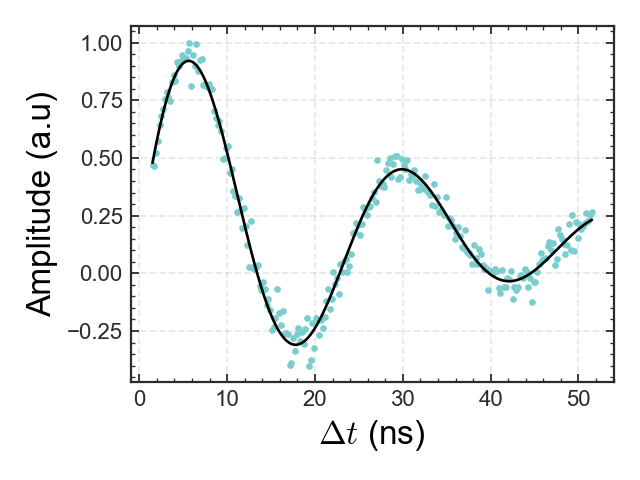

In [27]:
def rabi_model(t, tDec, T, A, B, C, D):
    """
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B) + C
    """

    return A * np.sin(2 * np.pi * t / T + B) * np.exp(-t / tDec) + C*t + D

FILENAME = "/Users/CCCP/creamy_seas/monday_starts_on_saturday/lab-results/2017-12-01_single-photon/2017_gnuplot/2017_12(Dec)_03_(first_photon_measurement)/labView_Photon_Source_Dec8'17_Q_osc_05_data.txt"
DATA = np.loadtxt(FILENAME)
x = DATA[:, 0]
y = DATA[:, 1] * 10**6
y = y/max(y)

popt, _ = curve_fit(rabi_model, x, y,
                           p0 = [
                               30, 24, 4, 0, 0, 1
                           ]    
                          )

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(x, y, linestyle="", marker="o", color="C4",)
ax.plot(x, 
        rabi_model(x, *popt), color="black"#color="#8b7e66"
       )
popt
plt.grid()

ax.set_xlabel("$\Delta{t}$ (ns)", fontsize=15)
ax.set_ylabel("Amplitude (a.u)", fontsize=15)
plt.tight_layout()
# plt.savefig(FILENAME.replace("txt", "svg"))

<IPython.core.display.Javascript object>


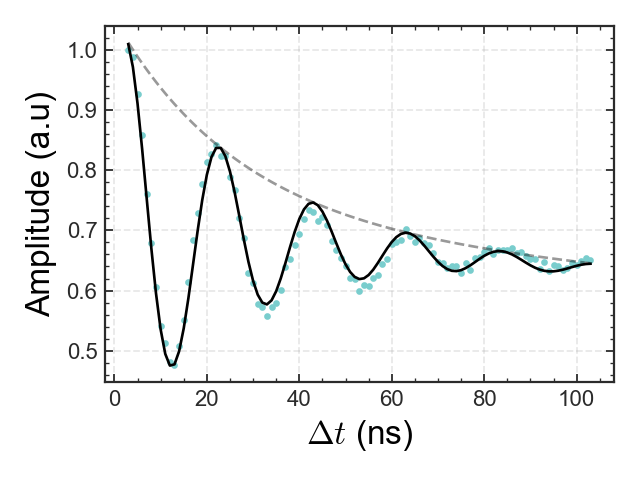

In [33]:

FILENAME = "./data/2021-08_photon-source/Ty_04_rabi-freq-sweep_vna0dBm.txt"
DATA = np.loadtxt(FILENAME)
with open(FILENAME) as fin:
    DATA = np.loadtxt(FILENAME)
    
    first_line = fin.readline().split()
    f_range = [float(first_line[1]), float(first_line[2]), DATA.shape[0]]
    
    second_line = fin.readline().split()
    y_range = [float(second_line[1]), float(second_line[2]), DATA.shape[1]]    


DATA.shape

x = np.linspace(*y_range)
y = DATA[7, :]
y /= max(y)

popt, _ = curve_fit(rabi_model, x, y,
                           p0 = [
                               30, 24, 4, 0, 0, 1
                           ]    
                          )

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(x, y, linestyle="", marker="o", color="C4",)
ax.plot(x, 
        rabi_model(x, *popt), color="black"
       )
ax.plot(x, 
        popt[2] * np.exp(-x / popt[0]) + popt[-2]*x + popt[-1], color="black",linestyle="--",alpha=0.4
       )
popt
plt.grid()



ax.set_xlabel("$\Delta{t}$ (ns)", fontsize=15)
ax.set_ylabel("Amplitude (a.u)", fontsize=15)
plt.tight_layout()
plt.savefig(FILENAME.replace(".txt", "_single.svg"))

<IPython.core.display.Javascript object>


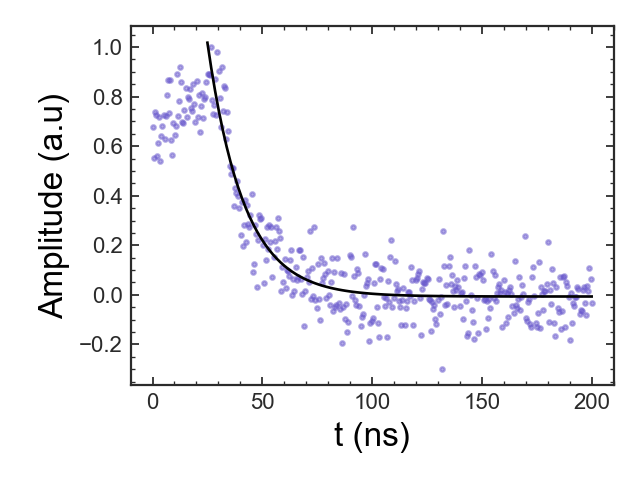

In [46]:

def exp_model(t, tDec, A, B):
    """
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B) + C
    """

    return A * np.exp(-t / tDec) + B

FILENAME = "./data/2017-12-01_single-photon/2017_gnuplot/2017_12(Dec)_03_(first_photon_measurement)/labView_Photon_Source_Dec8'17_T1_meas_09_data.txt"
DATA = np.loadtxt(FILENAME)
x = DATA[:, 0]
y = -DATA[:, 1]
y /= max(y)
popt, _ = curve_fit(exp_model, x[50:], y[50:],
                           p0 = [
                               44, 3, 10
                           ]    
                          )

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(x, y, linestyle="", marker="o", color="C5",alpha=0.5)
x = np.linspace(25, 200, 101)
ax.plot(x, 
        exp_model(x, *popt), color="black"
       )


ax.set_xlabel("t (ns)", fontsize=15)
ax.set_ylabel("Amplitude (a.u)", fontsize=15)
plt.tight_layout()
plt.savefig(FILENAME.replace("txt", "pdf"))

# Incoherent plotting

6.35946e-10

In [160]:
# FILENAME = "C:/ExperimentBlue/2021-08_photon-source/Ty_12_4.48GHz_-2dBm_incoherent-search_RBW-1MHz_all-amplifiers.txt"
FILENAME = "./data/2017-12-01_single-photon/Photon_Source_Dec8'17_SPA_incoherent_07_data.txt"

with open(FILENAME) as fin:
    data3d_z = np.transpose(np.loadtxt(FILENAME))
    MAX = np.amax(data3d_z)
    data3d_z /= MAX 
    
    first_line = fin.readline().split()
    data3d_x = np.linspace(float(first_line[1]), float(first_line[2]), data3d_z.shape[1])
    
    second_line = fin.readline().split()
    data3d_y = np.linspace(float(second_line[1]), float(second_line[2]), data3d_z.shape[0]) - 1000
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

<IPython.core.display.Javascript object>


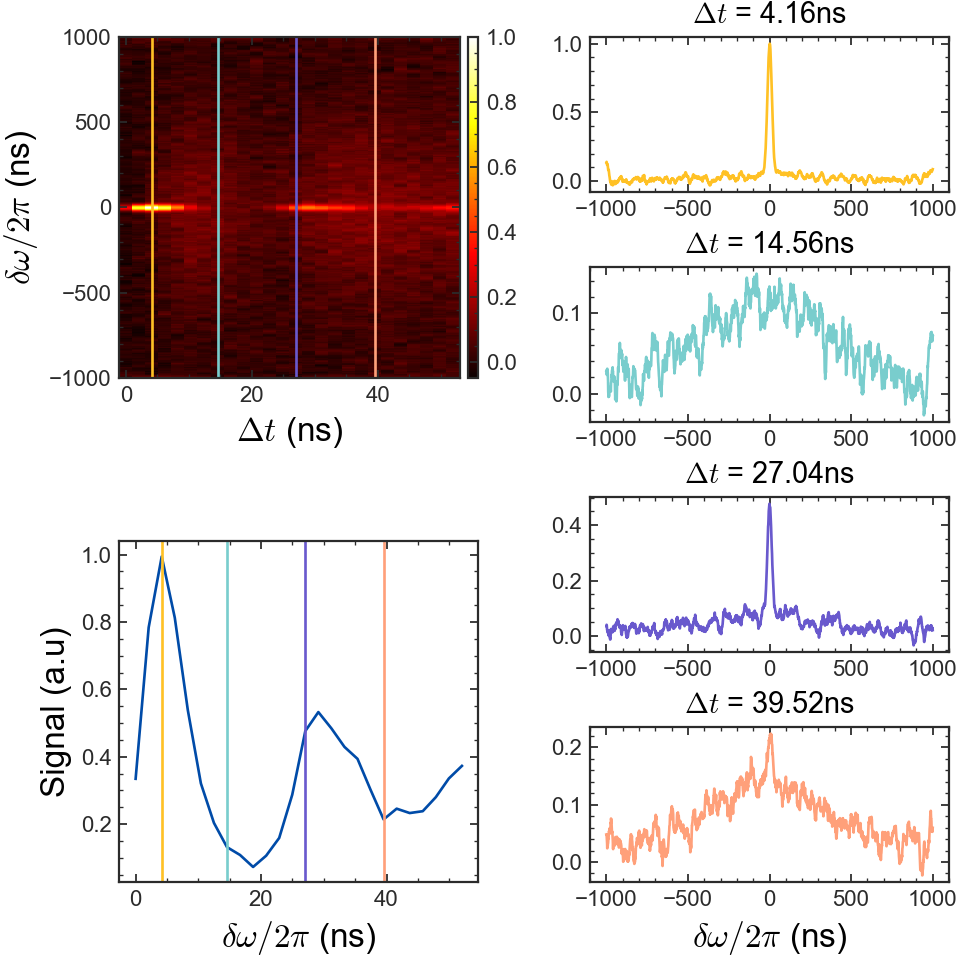

In [164]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(6, 6))
# Indexes where to slice
idx_list = [
#     (2, MY_COLOURS["DarkRed"]),
#     (7, MY_COLOURS["LightBlue"]),
#     (13, MY_COLOURS["Purple"]),
#     (19, MY_COLOURS["Sky"])    
    (2, "C3"),
    (7, "C4"),
    (13, "C5"),
    (19, "C6")    
]

ax = plt.subplot(221)
im = ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.hot,
                   rasterized=True
#               vmax=10
             )
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
# im.remove()
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("$\delta{\omega}/2\pi$ (ns)", fontsize=15)
ax.set_xlabel("$\Delta{t}$ (ns)", fontsize=15)

ax = plt.subplot(223)
ax.plot(data3d_x, data3d_z[len(data3d_y) // 2])
for idx, col in idx_list:
    ax.axvline(data3d_x[idx], color=col)
ax.set_ylabel("Signal (a.u)", fontsize=15)
ax.set_xlabel("$\delta{\omega}/2\pi$ (ns)", fontsize=15)

l = len(idx_list)
subplot_index = l*100 + 22
for i, (idx, col) in enumerate(idx_list):
    ax = plt.subplot(subplot_index + 2*i)
    ax.plot(data3d_y, 
            data3d_z[:,idx], 
             color=col,
#             label=f"@ {data3d_x[idx]:.2f}ns",
#             alpha=0.8+(i/l)*0.2, linewidth=l-i
           )
    ax.set_title(f"$\Delta{{t}}$ = {data3d_x[idx]}ns", size=13)
    ax.set_ylabel(" ", fontsize=11)
#     ax.set_ylabel("Signal (a.u)", fontsize=11)

ax.set_xlabel("$\delta{\omega}/2\pi$ (ns)", fontsize=15)
plt.tight_layout(pad=0.1)
plt.savefig(FILENAME.replace("txt", "svg"), dpi=100, transparent=True)

<IPython.core.display.Javascript object>


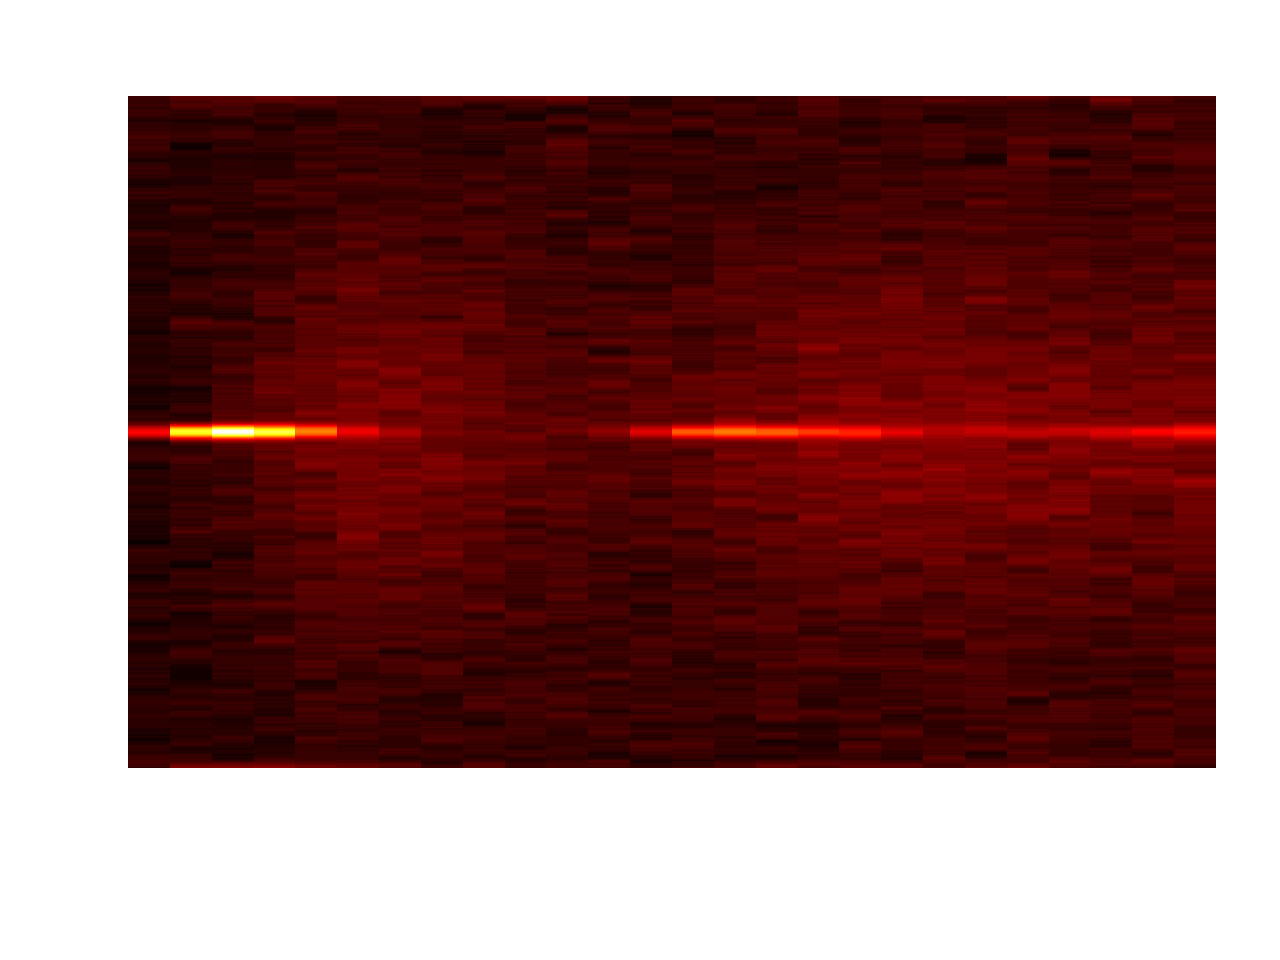

In [43]:
fig = plt.figure(figsize=(8, 6))
# fig.suptitle(FILENAME.split("/")[-1], fontsize=9)

# Indexes where to slice
idx_list = [
    (2, MY_COLOURS["DarkRed"]),
    (7, MY_COLOURS["LightBlue"]),
    (13, MY_COLOURS["Purple"]),
    (19, "black")    
]

ax = plt.subplot(111)
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.hot
             )
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax.axis('off') 
plt.savefig(FILENAME.replace("txt", "png"), dpi=300, transparent=True, bbox_inches='tight',pad_inches=0)

# Power sweep

<IPython.core.display.Javascript object>


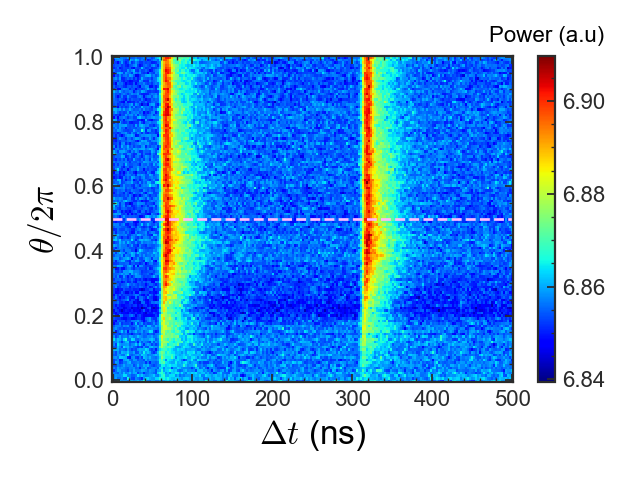

In [41]:
FILENAME = "/Users/CCCP/creamy_seas/monday_starts_on_saturday/lab-results/2017-12-01_single-photon/2017_gnuplot/2018_04(April)_first_correlations/data_labView_29Mar'18_incoherentSweep_98MHz.txt"
data3d_z = np.loadtxt(FILENAME) / 10**7
data3d_x = np.linspace(0, 500, data3d_z.shape[1])
data3d_y = np.linspace(0, 1, data3d_z.shape[0])
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)


fig = plt.figure(figsize=(4, 3))
CROSS = len(data3d_y) // 2

ax = plt.subplot(111)
ax.axhline(data3d_y[CROSS], color="#ffbbff", linestyle="--")
im = ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.jet,
              rasterized=True
             )
cbar = fig.colorbar(im, orientation='vertical')
cbar.ax.set_title("Power (a.u)", size=10)
# im.remove()


ax.set_ylabel(r"$\theta/2\pi$", fontsize=15)
ax.set_xlabel("$\Delta{t}$ (ns)", fontsize=15)
plt.tight_layout()

plt.savefig(FILENAME.replace("txt", "svg"), dpi=300, transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


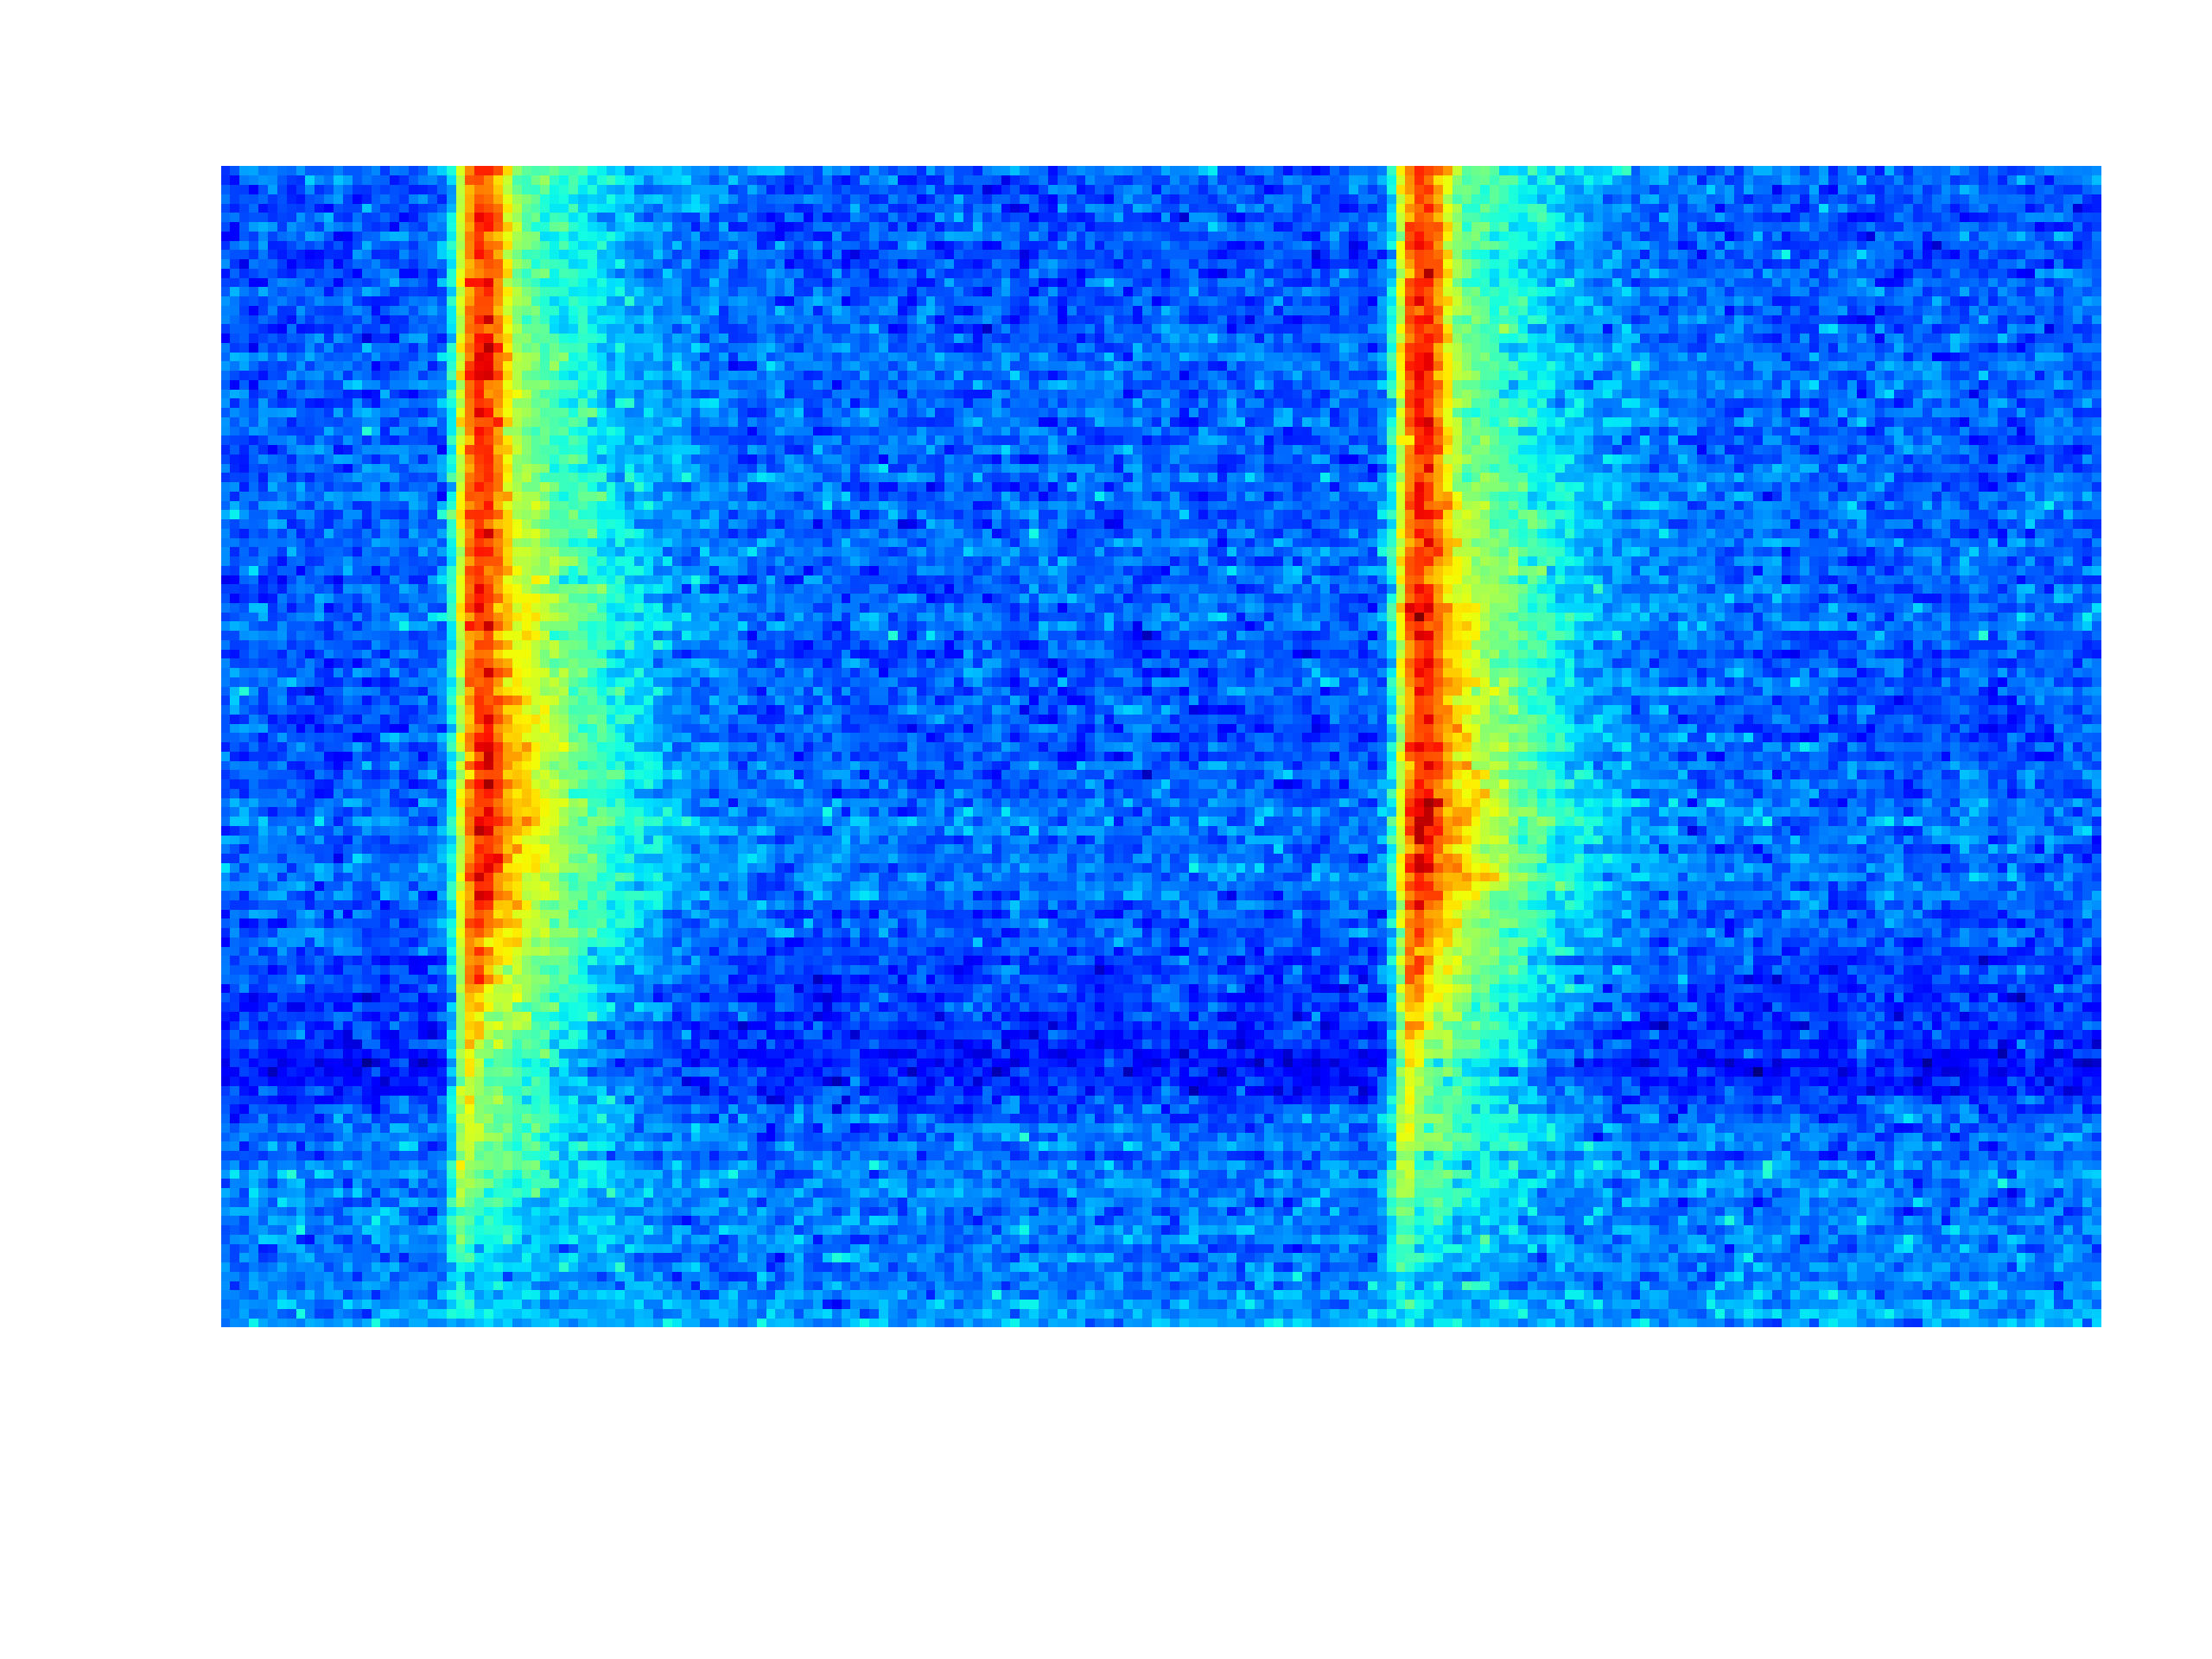

In [406]:
fig = plt.figure(figsize=(8, 6))
# fig.suptitle(FILENAME.split("/")[-1], fontsize=9)

ax = plt.subplot(111)
ax.pcolormesh(data3d_xmesh, data3d_ymesh, data3d_z,
              shading='nearest',
              cmap=cm.jet
             )
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
ax.axis('off') 
plt.savefig(FILENAME.replace("txt", "png"), dpi=100, transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


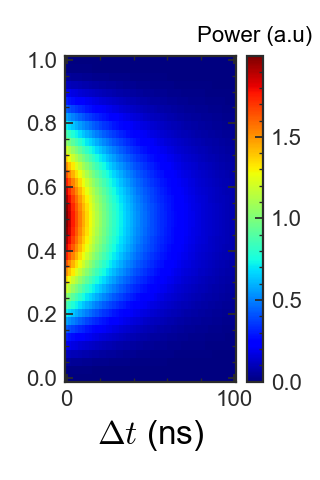

In [40]:
def power(t, theta):
    return (1 - np.cos(2*np.pi*theta)) * np.exp(-t/32)

data3d_x = np.linspace(0, 100, 50)
data3d_y = np.linspace(0, 1, 40)
data3d_xmesh, data3d_ymesh = np.meshgrid(data3d_x, data3d_y)

sim = power(data3d_xmesh, data3d_ymesh)

fig, ax = plt.subplots(1, 1, figsize=(2, 3))
im = ax.pcolormesh(data3d_xmesh, data3d_ymesh, sim,
              shading='nearest',
              cmap=cm.jet,
                   rasterized=True,
             )
cbar = fig.colorbar(im, orientation='vertical')
cbar.ax.set_title("Power (a.u)", size=10)
# ax.set_ylabel(r"$\theta/2\pi$", fontsize=15)
ax.set_xlabel("$\Delta{t}$ (ns)", fontsize=15)
plt.tight_layout()

plt.savefig(FILENAME.replace(".txt", "_simlation.svg"), dpi=100, transparent=True, bbox_inches='tight')

<IPython.core.display.Javascript object>


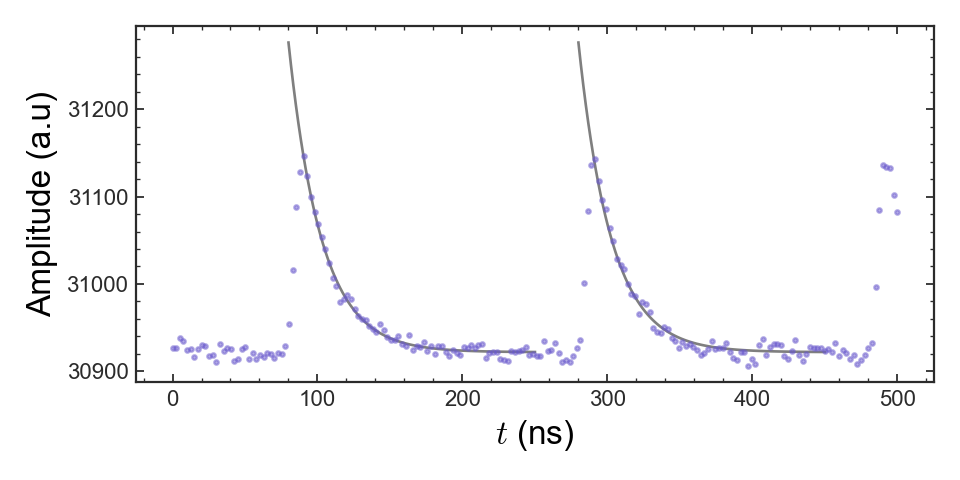

In [51]:

def exp_model(t, tDec, A, B):
    """
    __ Description __
    Fits Rabi oscillations of the format
    A e^(-t/tDec) cos(2π t / T + B) + C
    """

    return A * np.exp(-t / tDec) + B

FILENAME = "/Users/CCCP/creamy_seas/monday_starts_on_saturday/lab-results/2017-12-01_single-photon/2017_gnuplot/2018_04(April)_first_correlations/c++_Mar'18_piPulse(0)_98MHz.txt"
DATA = np.loadtxt(FILENAME)


y = DATA[:, 2] #* (2.2/2**13)**2
x = np.linspace(0, 500, len(y))

popt, _ = curve_fit(exp_model, x[36:100], y[36:100],
                           p0 = [
                               30, 31000, 10
                           ]    
                          )

fig, ax = plt.subplots(1,1,figsize=(6,3))
xh = np.linspace(80, 250, 101)
ax.plot(xh, exp_model(xh, *popt), color="black", alpha=0.5)
ax.plot(xh + 200, exp_model(xh, *popt), color="black", alpha=0.5)

ax.plot(x, y, linestyle="", marker="o", color="C5",
        alpha=0.5
       )

ax.set_xlabel("$t$ (ns)", fontsize=15)
ax.set_ylabel("Amplitude (a.u)", fontsize=15)
plt.tight_layout()
popt[0]
plt.savefig(FILENAME.replace(".txt", "_slice.svg"), dpi=100, transparent=True, bbox_inches='tight')